# Определение перспективного тарифа для телеком-компании

# Описание проекта

**«Мегалайн»** — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
<br>Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. 
<br>В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. 
<br>Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

# Описание тарифов
<b>Тариф «Смарт»</b>
<br>Ежемесячная плата: 550 рублей
<br>Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
<br>Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. <br>Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.
<br><b>Тариф «Ультра»</b>
<br>Ежемесячная плата: 1950 рублей
<br>Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
<br>Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.

# Описание данных
<b>Таблица `users` (информация о пользователях):</b>
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tarif — название тарифного плана

<br><b>Таблица `calls` (информация о звонках):</b>
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

<br><b>Таблица `messages` (информация о сообщениях):</b>
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

<br><b>Таблица `internet` (информация об интернет-сессиях):</b>
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

<br><b>Таблица `tariffs` (информация о тарифах):</b>
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

**Примечание:**
<br> «Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
<br> Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта

## Изучение данных из файлов

### Открытие файлов

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from scipy import stats as st
import math
import seaborn as sns

In [2]:
#загрузим данные
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv',index_col=0)
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

### Изучение данных

#### Таблица `calls`

**Изучим общую информацию**

In [3]:
calls.head()

id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000

In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [5]:
calls.describe()

duration        user_id
count  202607.000000  202607.000000
mean        6.755887    1253.940619
std         5.843365     144.722751
min         0.000000    1000.000000
25%         1.300000    1126.000000
50%         6.000000    1260.000000
75%        10.700000    1379.000000
max        38.000000    1499.000000

В таблице со звонками можно сделать следующее:
- привести столбцы к целым числам (тип `int`): `id` и `duration`(оператор округляет звонки до минуты)
- привести столбец `call_date` к типу `datetime`

#### Таблица `internet`

In [6]:
internet.head()

id  mb_used session_date  user_id
0  1000_0   112.95   2018-11-25     1000
1  1000_1  1052.81   2018-09-07     1000
2  1000_2  1197.26   2018-06-25     1000
3  1000_3   550.27   2018-08-22     1000
4  1000_4   302.56   2018-09-24     1000

In [7]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


In [8]:
internet.describe()

mb_used        user_id
count  149396.000000  149396.000000
mean      370.192426    1252.099842
std       278.300951     144.050823
min         0.000000    1000.000000
25%       138.187500    1130.000000
50%       348.015000    1251.000000
75%       559.552500    1380.000000
max      1724.830000    1499.000000

В таблице с интернетом можно сделать следующее:
- привести столбцы к целым числам (тип `int`): `id` и `mb_used`
- привести столбец `session_date` к типу `datetime`
- округлить данные столбца `mb_used` до гигабайтов (округление оператора)

#### Таблица `messages`

In [9]:
messages.head()

id message_date  user_id
0  1000_0   2018-06-27     1000
1  1000_1   2018-10-08     1000
2  1000_2   2018-08-04     1000
3  1000_3   2018-06-16     1000
4  1000_4   2018-12-05     1000

In [10]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [11]:
messages.describe()

user_id
count  123036.000000
mean     1256.989410
std       143.523967
min      1000.000000
25%      1134.000000
50%      1271.000000
75%      1381.000000
max      1499.000000

В таблице с сообщениями можно сделать следующее:
- привести столбец `id` к целым числам (тип `int`)
- привести столбец `message_date` к типу `datetime`

#### Таблица `tariffs`

In [12]:
tariffs.head()

messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   rub_monthly_fee  rub_per_gb  rub_per_message  rub_per_minute tariff_name  
0              550         200                3               3       smart  
1             1950         150                1               1       ultra

In [13]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [14]:
tariffs.describe()

messages_included  mb_per_month_included  minutes_included  \
count           2.000000               2.000000          2.000000   
mean          525.000000           23040.000000       1750.000000   
std           671.751442           10861.160159       1767.766953   
min            50.000000           15360.000000        500.000000   
25%           287.500000           19200.000000       1125.000000   
50%           525.000000           23040.000000       1750.000000   
75%           762.500000           26880.000000       2375.000000   
max          1000.000000           30720.000000       3000.000000   

       rub_monthly_fee  rub_per_gb  rub_per_message  rub_per_minute  
count         2.000000    2.000000         2.000000        2.000000  
mean       1250.000000  175.000000         2.000000        2.000000  
std         989.949494   35.355339         1.414214        1.414214  
min         550.000000  150.000000         1.000000        1.000000  
25%         900.000000  162.500000         1.500000        1.500000  
50%        1250.000000  175.000000         2.000000        2.000000  
75%        1600.000000  187.500000         2.500000        2.500000  
max        1950.000000  200.000000         3.000000        3.000000

Тут все в порядке

#### Таблица `users`

In [15]:
users.head()

user_id  age churn_date         city first_name  last_name    reg_date  \
0     1000   52        NaN    Краснодар     Рафаил  Верещагин  2018-05-25   
1     1001   41        NaN       Москва       Иван       Ежов  2018-11-01   
2     1002   59        NaN  Стерлитамак    Евгений  Абрамович  2018-06-17   
3     1003   23        NaN       Москва      Белла   Белякова  2018-08-17   
4     1004   68        NaN  Новокузнецк    Татьяна   Авдеенко  2018-05-14   

  tariff  
0  ultra  
1  smart  
2  smart  
3  ultra  
4  ultra

In [16]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [17]:
users.describe()

user_id        age
count   500.000000  500.00000
mean   1249.500000   46.58800
std     144.481833   16.66763
min    1000.000000   18.00000
25%    1124.750000   32.00000
50%    1249.500000   46.00000
75%    1374.250000   62.00000
max    1499.000000   75.00000

В таблице с пользователями можно сделать следующее:
- привести столбец `reg_date` к типу `datetime`

### Вывод
<br> - данные содержат записи о 500 клиентах;
<br> - в данных требуется скорректировать типы, округлить звонки и мегабайты по условиям округления оператора;
<br> - нулевые данные по звонкам говорят, что звонки были пропущены, соответственно нулевые значения менять не стоит;
<br> - необходимо столбцы с тарифом в таблицах `users` и `tariffs` привести к единому имени `tariff`

In [18]:
print('Количество интернет трафика равным нулю:', internet.loc[internet['mb_used'] == 0, 'mb_used'].value_counts()[0])
print('Количество интернет трафика равным единице:', internet.loc[internet['mb_used'] == 1, 'mb_used'].value_counts()[1])
print('Всего записей по интернет трафику:', internet['id'].count())

Количество интернет трафика равным нулю: 19598
Количество интернет трафика равным единице: 1
Всего записей по интернет трафику: 149396


## Подготовка данных

### Замена типов данных в таблицах

Изменим типы данных в таблицах

In [19]:
# заменим типы данных в столбцах с датой
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

In [20]:
# заменим типы данных на целые
calls['duration'] = np.ceil(calls['duration']).astype('int')
calls['id'] = calls['id'].astype('int')
internet['id'] = internet['id'].astype('int')
internet['mb_used'] = np.ceil(internet['mb_used']).astype('int')
messages['id'] = messages['id'].astype('int')

In [21]:
internet.head()

id  mb_used session_date  user_id
0  10000      113   2018-11-25     1000
1  10001     1053   2018-09-07     1000
2  10002     1198   2018-06-25     1000
3  10003      551   2018-08-22     1000
4  10004      303   2018-09-24     1000

Все данные в столбцах были приведены к корректным форматам

### Переименование столбцов

Приведем столбцы с тарифом в таблицах `users` и `tariffs` к единому имени `tariff`

In [22]:
tariffs = tariffs.rename(columns={'tariff_name':'tariff'})
tariffs.head()

messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   rub_monthly_fee  rub_per_gb  rub_per_message  rub_per_minute tariff  
0              550         200                3               3  smart  
1             1950         150                1               1  ultra

### Дополнительные расчеты

**Посчитаем для каждого пользователя:**
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя.

**Расчет кол-ва сделанных звонков и израсходованных минут по месяцам**

In [23]:
# добавим столбец с месяцем в таблице `calls`
calls['month'] = calls['call_date'].dt.month

In [24]:
# расчитаем сводную таблицу, сгруппированную по кол-ву звонкам и их продолжительностью в месяц
user_calls = calls.pivot_table(index = ['user_id', 'month'], values='duration', aggfunc={'user_id': 'count', 'duration': 'sum'})
user_calls.columns = ['month_calls_duration', 'month_calls_total']
user_calls.head(10)


month_calls_duration  month_calls_total
user_id month                                         
1000    5                       159                 22
        6                       172                 43
        7                       340                 47
        8                       408                 52
        9                       466                 58
        10                      350                 57
        11                      338                 43
        12                      333                 46
1001    11                      430                 59
        12                      414                 63

**Расчет кол-ва отправленных сообщений по месяцам**

In [25]:
# добавим столбец с месяцем в таблице `messages`
messages['month'] = messages['message_date'].dt.month

In [26]:
# расчитаем сводную таблицу, сгруппированную по кол-ву сообщений в месяц
user_messages = messages.pivot_table(index = ['user_id', 'month'], values='id', aggfunc= 'count')
user_messages.columns = ['month_sms_total']
user_messages.head(10)

month_sms_total
user_id month                 
1000    5                   22
        6                   60
        7                   75
        8                   81
        9                   57
        10                  73
        11                  58
        12                  70
1002    6                    4
        7                   11

**Расчет израсходованного трафика по месяцам**

In [27]:
# добавим столбец с месяцем в таблице `internet`
internet['month'] = internet['session_date'].dt.month

In [28]:
# расчитаем сводную таблицу, сгруппированную по кол-ву сообщений в месяц
user_internet = internet.pivot_table(index = ['user_id', 'month'], values='mb_used', aggfunc= 'sum')
user_internet.columns = ['month_mb_total']
user_internet.head(10)

month_mb_total
user_id month                
1000    5                2256
        6               23257
        7               14016
        8               14070
        9               14581
        10              14717
        11              14768
        12               9827
1001    11              18452
        12              14053

**Расчет помесячной выручки с каждого пользователя**

In [29]:
# добавим столбец с месяцем в таблице `users`
users['month'] = users['reg_date'].dt.month

In [30]:
# соеденим 2 сводные таблицы, созданные выше, в одну
df = user_calls.merge(user_messages, on=['user_id','month'], how='outer')
# прибавим к df таблицу user_internet
df = df.merge(user_internet, on=['user_id','month'], how = 'outer')
# прибавим слева данные таблицы users с информацией по пользователям с городом и тарифом
df = df.merge(users[['user_id', 'city', 'tariff']], on='user_id', how='left')
# прибавим слева данные таблицы по тарифам
df = df.merge(tariffs, on='tariff', how='left')
df.head()

user_id  month_calls_duration  month_calls_total  month_sms_total  \
0     1000                 159.0               22.0             22.0   
1     1000                 172.0               43.0             60.0   
2     1000                 340.0               47.0             75.0   
3     1000                 408.0               52.0             81.0   
4     1000                 466.0               58.0             57.0   

   month_mb_total       city tariff  messages_included  mb_per_month_included  \
0          2256.0  Краснодар  ultra               1000                  30720   
1         23257.0  Краснодар  ultra               1000                  30720   
2         14016.0  Краснодар  ultra               1000                  30720   
3         14070.0  Краснодар  ultra               1000                  30720   
4         14581.0  Краснодар  ultra               1000                  30720   

   minutes_included  rub_monthly_fee  rub_per_gb  rub_per_message  \
0              3000             1950         150                1   
1              3000             1950         150                1   
2              3000             1950         150                1   
3              3000             1950         150                1   
4              3000             1950         150                1   

   rub_per_minute  
0               1  
1               1  
2               1  
3               1  
4               1

In [31]:
# проверим наличие пустых значений методом isna
df.isna().sum().sort_values()

user_id                    0
city                       0
tariff                     0
messages_included          0
mb_per_month_included      0
minutes_included           0
rub_monthly_fee            0
rub_per_gb                 0
rub_per_message            0
rub_per_minute             0
month_mb_total            11
month_calls_duration      40
month_calls_total         40
month_sms_total          497
dtype: int64

In [32]:
# заполним пустые значения в столбцах month_calls_duration, month_calls_total, month_sms_total, month_mb_total
columns_list = ['month_calls_duration', 'month_calls_total', 'month_sms_total', 'month_mb_total']
for col in columns_list:
    df[col] = df[col].fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 14 columns):
user_id                  3214 non-null int64
month_calls_duration     3214 non-null float64
month_calls_total        3214 non-null float64
month_sms_total          3214 non-null float64
month_mb_total           3214 non-null float64
city                     3214 non-null object
tariff                   3214 non-null object
messages_included        3214 non-null int64
mb_per_month_included    3214 non-null int64
minutes_included         3214 non-null int64
rub_monthly_fee          3214 non-null int64
rub_per_gb               3214 non-null int64
rub_per_message          3214 non-null int64
rub_per_minute           3214 non-null int64
dtypes: float64(4), int64(8), object(2)
memory usage: 376.6+ KB


In [33]:
# проверим данные на наличие дубликатов
print('Количество дубликатов:', df.duplicated().sum())

Количество дубликатов: 0


In [34]:
# создадим функцию для расчета затрат клиента сверх тарифа в месяц

def costs_above_tariff(row):
    minuts = (row['month_calls_total'] - row['minutes_included']) * row['rub_per_minute']
    messages = (row['month_sms_total'] - row['messages_included']) * row['rub_per_message']
    mbs = np.ceil((row['month_mb_total'] - row['mb_per_month_included']) * row['rub_per_gb'] / 1024)
    total = 0
    for i in [messages, minuts, mbs]:
        if i > 0:
            total += i
    return total

In [35]:
# добавим столбец с расходами сверх тарифа
df['costs_above_tariff'] = df.apply(lambda x: costs_above_tariff(x), axis=1)

In [36]:
# добавим столбец с общей выручкой в месяц
df['total_paid'] = df['rub_monthly_fee'] + df['costs_above_tariff']

In [37]:
df.head(20)

user_id  month_calls_duration  month_calls_total  month_sms_total  \
0      1000                 159.0               22.0             22.0   
1      1000                 172.0               43.0             60.0   
2      1000                 340.0               47.0             75.0   
3      1000                 408.0               52.0             81.0   
4      1000                 466.0               58.0             57.0   
5      1000                 350.0               57.0             73.0   
6      1000                 338.0               43.0             58.0   
7      1000                 333.0               46.0             70.0   
8      1001                 430.0               59.0              0.0   
9      1001                 414.0               63.0              0.0   
10     1002                 117.0               15.0              4.0   
11     1002                 214.0               26.0             11.0   
12     1002                 289.0               42.0             13.0   
13     1002                 206.0               36.0              4.0   
14     1002                 212.0               33.0             10.0   
15     1002                 243.0               32.0             16.0   
16     1002                 236.0               33.0             12.0   
17     1003                 380.0               55.0             37.0   
18     1003                 961.0              134.0             91.0   
19     1003                 855.0              108.0             83.0   

    month_mb_total         city tariff  messages_included  \
0           2256.0    Краснодар  ultra               1000   
1          23257.0    Краснодар  ultra               1000   
2          14016.0    Краснодар  ultra               1000   
3          14070.0    Краснодар  ultra               1000   
4          14581.0    Краснодар  ultra               1000   
5          14717.0    Краснодар  ultra               1000   
6          14768.0    Краснодар  ultra               1000   
7           9827.0    Краснодар  ultra               1000   
8          18452.0       Москва  smart                 50   
9          14053.0       Москва  smart                 50   
10         10871.0  Стерлитамак  smart                 50   
11         17601.0  Стерлитамак  smart                 50   
12         20347.0  Стерлитамак  smart                 50   
13         16712.0  Стерлитамак  smart                 50   
14         13905.0  Стерлитамак  smart                 50   
15         18610.0  Стерлитамак  smart                 50   
16         18137.0  Стерлитамак  smart                 50   
17          8571.0       Москва  ultra               1000   
18         12479.0       Москва  ultra               1000   
19         14779.0       Москва  ultra               1000   

    mb_per_month_included  minutes_included  rub_monthly_fee  rub_per_gb  \
0                   30720              3000             1950         150   
1                   30720              3000             1950         150   
2                   30720              3000             1950         150   
3                   30720              3000             1950         150   
4                   30720              3000             1950         150   
5                   30720              3000             1950         150   
6                   30720              3000             1950         150   
7                   30720              3000             1950         150   
8                   15360               500              550         200   
9                   15360               500              550         200   
10                  15360               500              550         200   
11                  15360               500              550         200   
12                  15360               500              550         200   
13                  15360               500              550         200   
14                  15360               500     

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 16 columns):
user_id                  3214 non-null int64
month_calls_duration     3214 non-null float64
month_calls_total        3214 non-null float64
month_sms_total          3214 non-null float64
month_mb_total           3214 non-null float64
city                     3214 non-null object
tariff                   3214 non-null object
messages_included        3214 non-null int64
mb_per_month_included    3214 non-null int64
minutes_included         3214 non-null int64
rub_monthly_fee          3214 non-null int64
rub_per_gb               3214 non-null int64
rub_per_message          3214 non-null int64
rub_per_minute           3214 non-null int64
costs_above_tariff       3214 non-null float64
total_paid               3214 non-null float64
dtypes: float64(6), int64(8), object(2)
memory usage: 426.9+ KB


### Вывод
<br> - типы данных были скорректированы
<br> - столбцы с названием тарифа были приведены к единообразию
<br> - в результате по каждому пользователю была расчитана выручка

## Анализ данных

**В ходе исследования выполним следующее:**

- определим сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифав месяц? 
- посчитаем среднее количество, дисперсию и стандартное отклонение;
- построим гистограммы и опишем распределения.

### Количество минут, смс и Мб в месяц по пользователям для каждого тарифа

In [39]:
df.head(10)

user_id  month_calls_duration  month_calls_total  month_sms_total  \
0     1000                 159.0               22.0             22.0   
1     1000                 172.0               43.0             60.0   
2     1000                 340.0               47.0             75.0   
3     1000                 408.0               52.0             81.0   
4     1000                 466.0               58.0             57.0   
5     1000                 350.0               57.0             73.0   
6     1000                 338.0               43.0             58.0   
7     1000                 333.0               46.0             70.0   
8     1001                 430.0               59.0              0.0   
9     1001                 414.0               63.0              0.0   

   month_mb_total       city tariff  messages_included  mb_per_month_included  \
0          2256.0  Краснодар  ultra               1000                  30720   
1         23257.0  Краснодар  ultra               1000                  30720   
2         14016.0  Краснодар  ultra               1000                  30720   
3         14070.0  Краснодар  ultra               1000                  30720   
4         14581.0  Краснодар  ultra               1000                  30720   
5         14717.0  Краснодар  ultra               1000                  30720   
6         14768.0  Краснодар  ultra               1000                  30720   
7          9827.0  Краснодар  ultra               1000                  30720   
8         18452.0     Москва  smart                 50                  15360   
9         14053.0     Москва  smart                 50                  15360   

   minutes_included  rub_monthly_fee  rub_per_gb  rub_per_message  \
0              3000             1950         150                1   
1              3000             1950         150                1   
2              3000             1950         150                1   
3              3000             1950         150                1   
4              3000             1950         150                1   
5              3000             1950         150                1   
6              3000             1950         150                1   
7              3000             1950         150                1   
8               500              550         200                3   
9               500              550         200                3   

   rub_per_minute  costs_above_tariff  total_paid  
0               1                 0.0      1950.0  
1               1                 0.0      1950.0  
2               1                 0.0      1950.0  
3               1                 0.0      1950.0  
4               1                 0.0      1950.0  
5               1                 0.0      1950.0  
6               1                 0.0      1950.0  
7               1                 0.0      1950.0  
8               3               604.0      1154.0  
9               3                 0.0       550.0

In [40]:
# создадим сводную таблицу со значениями в месяц минут, мб и смс для каждого тарифа
#monthly_sum = df.pivot_table(index = 'user_id', values=['month_calls_duration', 'month_sms_total', 'month_mb_total','total_paid'], aggfunc= 'sum')
#for user_id in users['user_id']:
#    monthly_sum.loc[user_id, 'tariff'] = users.loc[user_id-1000, 'tariff']
#monthly_sum.head(10)


In [41]:
df.pivot_table(index = 'tariff', values=['month_calls_duration', 'month_sms_total', 'month_mb_total',
                                                           'total_paid'], aggfunc= ['sum'])

sum                                          
       month_calls_duration month_mb_total month_sms_total total_paid
tariff                                                               
smart              931577.0     36174861.0         74413.0  2471569.0
ultra              518724.0     19194598.0         48623.0  2029690.0

### Среднее количество, дисперсия и стандартное отклонение

In [42]:
# в сводной таблице расчитаем медианное значение, стандартное отклонение и дисперсию
deviations = df.pivot_table(index=['tariff'], values=['month_calls_duration', 'month_mb_total', 'month_sms_total', 'total_paid'], 
                    aggfunc={'month_calls_duration': [np.median, np.var, np.std],
                             'month_mb_total': [np.median, np.var, np.std], 
                             'month_sms_total': [np.median, np.var, np.std],
                             'total_paid': [np.median, np.var, np.std]})
deviations


month_calls_duration                            month_mb_total  \
                     median         std            var         median   
tariff                                                                  
smart                 422.0  190.313730   36219.315784        16531.0   
ultra                 518.0  317.606098  100873.633397        19324.0   

                                   month_sms_total                          \
                 std           var          median        std          var   
tariff                                                                       
smart    5877.576978  3.454591e+07            28.0  28.227876   796.812958   
ultra   10096.317202  1.019356e+08            38.0  47.804457  2285.266143   

       total_paid                             
           median         std            var  
tariff                                        
smart       797.0  708.095669  501399.477137  
ultra      1950.0  356.455650  127060.630690

По тарифу "Ультра" минуты разговора, объем потраченного интернет-трафика и число сообщений имеет большие медианы, стандартное отклонение и дисперсию по сравнению с тарифом «Смарт».

### Гистограммы

Построим матрицу диаграмм рассеивания по тарифу `Smart`

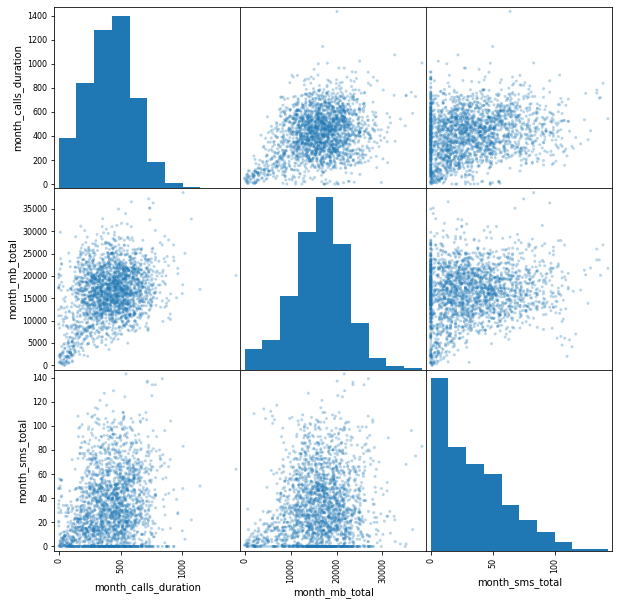

In [43]:
pd.plotting.scatter_matrix(df[df['tariff'] == 'smart']
                           [['month_calls_duration', 'month_mb_total', 'month_sms_total']],
                           alpha = 0.3, figsize = (10,10));

Построим матрицу диаграмм рассеивания по тарифу `Ultra`

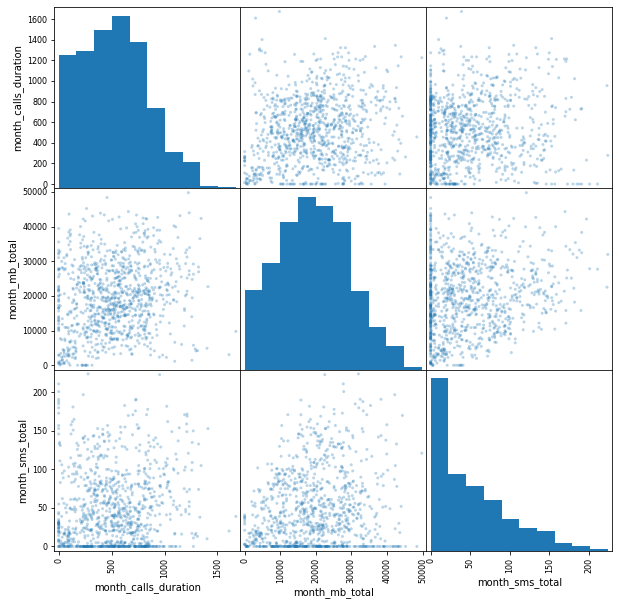

In [44]:
pd.plotting.scatter_matrix(df[df['tariff'] == 'ultra']
                           [['month_calls_duration', 'month_mb_total', 'month_sms_total']],
                           alpha = 0.3, figsize = (10,10));

### Вывод

По гистограммам по звонкам и интернет трафику распределения нормальные.
<br> По гистограмме сообщений распределение Пуассона.
<br> Гистограммы подтверждают предыдущие наблюдения, о том, что дисперсия по тарифу "Смарт" меньше, чем по тарифу "Ультра" по всем рассматриваемым параметрам: 
- по длительности разговора;
- по объему интернет-трафика;
- числу сообщений.

Это подтверждает тот факт, что по более дорогому тарифу, размах действий пользователей шире и свободнее по всем показателям.

## Проверка гипотез

**Проверим следующие гипотезы:**
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

**Сформулируем первую гипотезe:**

<br> Гипотеза H1 формируется из задания, соответственно, нулевая гипотеза будет ей противоположна.

<br> H0: средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается
<br> H1: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
<br> alpha примем равную 5%

### Проверка гипотезы о различиях средней выручки тарифов "Смарт" и "Ультра" 

In [46]:
# создадим две новые таблицы с выручкой по тарифам
ultra = df.query('tariff == "ultra"')['total_paid']
smart = df.query('tariff == "smart"')['total_paid']

alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу


results = st.ttest_ind(ultra, smart)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.6680337030884488e-284
Отвергаем нулевую гипотезу


Средние значения выручки по тарифам различаются почти в 2 раза (924 по тарифу "Смарт" против 1950 руб по тарифу "Ультра"). 
<br> Исходя из этого, можно утверждать, что доходы "Мегалайна" по тарифу "Ультра" отличаются по сравнению с доходами от тарифа "Смарт", а не равны.

### Проверка гипетозу об отличии средней выручки пользователей Москвы и регионов

**Сформулируем вторую гипотезу:**

<br> Гипотеза Н1 формируется из задания, соответственно, нулевая гипотеза будет ей противоположна.

<br> H0: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов
<br> H1: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов
<br> alpha примем равную 5%

In [47]:
# создадим две таблицы, с клиентами Москвы и прочими

moscow = df.query('city == "Москва"')['total_paid']
others = df.query('city != "Москва"')['total_paid']

alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу

results = st.ttest_ind(moscow, others)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.24536086905691057
Не получилось отвергнуть нулевую гипотезу


Данный тест не позволил отвергнуть исходную гипотезу, т.к. с вероятностью примерно 24% доходы от пользователей из Москвы и из других регионов будут равными. Отвергаем альтернативную гипотезу H1.

In [48]:
def region(city):
    if city == 'Москва': return 'Москва'
    else: return 'Другой'
    
df['region'] = df['city'].apply(region)
df.pivot_table(index='region', values='total_paid', aggfunc='median')

total_paid
region            
Другой      1374.0
Москва      1597.0

In [49]:
df.describe()

user_id  month_calls_duration  month_calls_total  month_sms_total  \
count  3214.000000           3214.000000        3214.000000      3214.000000   
mean   1251.590230            451.244866          63.038892        38.281269   
std     144.659172            241.909978          33.236368        36.148326   
min    1000.000000              0.000000           0.000000         0.000000   
25%    1125.000000            282.000000          40.000000         9.000000   
50%    1253.000000            443.000000          62.000000        30.000000   
75%    1378.750000            589.000000          82.000000        57.000000   
max    1499.000000           1673.000000         244.000000       224.000000   

       month_mb_total  messages_included  mb_per_month_included  \
count     3214.000000        3214.000000            3214.000000   
mean     17227.585252         341.148102           20067.405103   
std       7578.261501         438.044726            7082.491569   
min          0.000000          50.000000           15360.000000   
25%      12505.250000          50.000000           15360.000000   
50%      16966.500000          50.000000           15360.000000   
75%      21450.000000        1000.000000           30720.000000   
max      49789.000000        1000.000000           30720.000000   

       minutes_included  rub_monthly_fee   rub_per_gb  rub_per_message  \
count       3214.000000      3214.000000  3214.000000      3214.000000   
mean        1266.179216       979.060361   184.676416         2.387057   
std         1152.749279       645.539596    23.054986         0.922199   
min          500.000000       550.000000   150.000000         1.000000   
25%          500.000000       550.000000   150.000000         1.000000   
50%          500.000000       550.000000   200.000000         3.000000   
75%         3000.000000      1950.000000   200.000000         3.000000   
max         3000.000000      1950.000000   200.000000         3.000000   

       rub_per_minute  costs_above_tariff   total_paid  
count     3214.000000         3214.000000  3214.000000  
mean         2.387057          421.455818  1400.516179  
std          0.922199          655.221442   761.052426  
min          1.000000            0.000000   550.000000  
25%          1.000000            0.000000   582.250000  
50%          3.000000           15.000000  1396.000000  
75%          3.000000          698.000000  1950.000000  
max          3.000000         4641.000000  5191.000000

In [50]:
df.pivot_table(index='tariff', values='total_paid', aggfunc='median')

total_paid
tariff            
smart        797.0
ultra       1950.0

### Вывод

1. По результатам проведенного анализа можно сделать вывод, что доходы **"Мегалайн"** от тарифа `Ультра` больше, чем от тарифа `Смарт` в 2,4 раза (соответственнно, он более выгодный для компании).

<br> Особенности использования тарифов пользователями:

- По тарифу `Смарт` не хватает включенных базовых услуг в рамках тарифного пакета: кроме абонентской платы пользователи в среднем доплачивают еще к абонентской плате 274 рублей в месяц.
- По тарифу `Ультра`, наоборот, пользователям всего хватает и они не превышают лимиты свыше включенных в абонентскую плату.

2. Средние доходы от пользователей в Москве не отличаются от доходов в других регионах. Разница здесь может составлять 16%  по средней выручке(незначительна в сравнении с первой гипотезой, где разница выручки отличается в 2 раза): 
- Москва - 1597 руб, 
- другой регион - 1374 руб.
